In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_path = "./data/"
df_train = pd.read_csv(data_path + "train.csv")
df_test = pd.read_csv(data_path + "test.csv")

# drop id
df_train.drop('id', axis=1, inplace=True)

In [ ]:
# helper functions
import requests
import holidays

# gdp feature

def get_gdp_per_capita(country,year):
    alpha3 = {'Argentina':'ARG','Canada':'CAN','Estonia':'EST','Japan':'JPN','Spain':'ESP'}
    url="https://api.worldbank.org/v2/country/{0}/indicator/NY.GDP.PCAP.CD?date={1}&format=json".format(alpha3[country],year)
    response = requests.get(url).json()
    return response[1][0]['value']

def create_gdp_df(df):
    gdp = []
    for country in df.country.unique():
        row = []
        for year in range(2017,2023):
            row.append(get_gdp_per_capita(country,year))
        gdp.append(row)

    gdp = np.array(gdp)
    gdp /= np.sum(gdp,axis=0)

    rel_gdp_df = pd.DataFrame(gdp,index=df.country.unique(),columns=range(2017,2023))
    return rel_gdp_df

def add_gdp_feature(df):
    rel_gdp_df_0 = create_gdp_df(df)
    rel_gdp_df = rel_gdp_df_0.reset_index(names="country")
    rel_gdp_df = pd.melt(rel_gdp_df, id_vars='country', value_vars=[2017, 2018, 2019, 2020, 2021, 2022])
    rel_gdp_df.columns = ['country', 'year', 'rel_gdp']
    rel_gdp_df['year'] = rel_gdp_df['year'].astype(int)
    df = df.merge(rel_gdp_df, on=['year', 'country'], how='left')
    return df

# holidays feature

def create_holidays_df():
    years = [2017, 2018, 2019, 2020, 2021, 2022, 2023]

    countries = {
        "AR": "Argentina",
        "CA": "Canada",
        "EE": "Estonia",
        "ES": "Spain",
        "JP": "Japan"
    }


    Argentina_holidays = holidays.CountryHoliday('AR', years=years)
    Canada_holidays = holidays.CountryHoliday('CA', years=years)
    Estonia_holidays = holidays.CountryHoliday('EE', years=years)
    Spain_holidays = holidays.CountryHoliday('ES', years=years)
    Japan_holidays = holidays.CountryHoliday('JP', years=years)

    all_holidays = [Argentina_holidays, Canada_holidays, Estonia_holidays, Spain_holidays, Japan_holidays]



    holidays_dfs = []
    for country_holidays in all_holidays:
        holidays_dates = []
        for date in country_holidays:
            holidays_dates.append(date)

        holidays_dates = list(set(holidays_dates))

        hdf = pd.DataFrame(holidays_dates, columns=['date'])
        hdf['country'] = countries[country_holidays.country]

        holidays_dfs.append(hdf)

    holidays_df = pd.concat(holidays_dfs)

    holidays_df['is_holiday'] = True

    holidays_df['date'] = pd.to_datetime(holidays_df['date'])
    return holidays_df

def add_holiday_feature(df):
    holidays_df = create_holidays_df()
    df = df.merge(holidays_df, on=['date', 'country'], how='left')
    df['is_holiday'] = df['is_holiday'].fillna(False)
    df['is_holiday'] = df['is_holiday'].astype(int)
    return df


def transform_date(df):
    df['date'] = pd.to_datetime(df['date'])
    return df

def create_features(df):
    # split date into year, month, day
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day

    # week number
    df['week_number'] = df['date'].dt.isocalendar().week.astype(int)
    
    # day of week
    df['dayofweek'] = df['date'].dt.dayofweek
    df['dayofmonth'] = df['date'].dt.day
    # weekend
    df['weekend'] = (df['date'].dt.weekday >=4).astype(int)

    df['country'] = df['country'].astype('category')
    df['store'] = df['store'].astype('category')
    df['product'] = df['product'].astype('category')

    return df

def encode_cat_variables(df):
    categorical_features = ["country", "store", "product"]
    df = pd.get_dummies(df, columns=categorical_features)
    return df

def seasonality_features(df):
    df['month_sin'] = np.sin(2*np.pi*df.month/12)
    df['month_cos'] = np.cos(2*np.pi*df.month/12)
    df['day_sin'] = np.sin(2*np.pi*df.dayofmonth/31)
    df['day_cos'] = np.cos(2*np.pi*df.dayofmonth/31)
    return df

def SMAPE(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [28]:
df_train = transform_date(df_train)
df_train = create_features(df_train)
df_train = seasonality_features(df_train)
df_train = add_gdp_feature(df_train)
df_train = add_holiday_feature(df_train)
df_train = encode_cat_variables(df_train)


df_test_0 = transform_date(df_test)
df_test_0 = create_features(df_test_0)
df_test_0 = seasonality_features(df_test_0)
df_test_0 = add_gdp_feature(df_test_0)
df_test_0 = add_holiday_feature(df_test_0)
df_test_0 = encode_cat_variables(df_test_0)

model_features = df_train.columns.tolist()
model_features.remove("num_sold")
model_features.remove("date")

X_train = df_train[model_features]
y_train = df_train["num_sold"]

X_test = df_test_0[model_features]

Submission saved to seasonality_holidays_etc_xgb_submission.csv


<Axes: xlabel='date', ylabel='num_sold'>

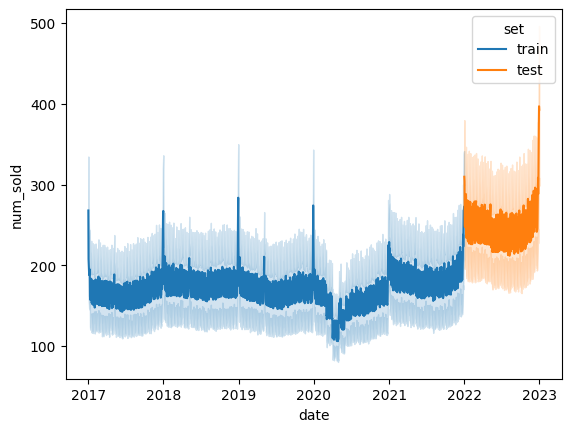

In [29]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from catboost import Pool, CatBoostRegressor



model_xgb = xgb.XGBRegressor(tree_method="gpu_hist", enable_categorical=True)
name = "seasonality_holidays_etc_xgb"
model_xgb.fit(
    X_train, y_train,
    verbose=False,
)

df_test['num_sold'] = np.round(model_xgb.predict(X_test)).astype(int)

coef_c = {'Argentina': 4.23, 'Spain': 1.500, 'Japan': 1.14, 'Estonia': 1.62, 'Canada': 0.87}
for c, country in enumerate(df_test['country'].unique()):
    df_test.loc[(df_test['country'] == country), 'num_sold'] *= coef_c[country]

submission_df = df_test[['id', 'num_sold']]
submission_df.to_csv(f'{name}_submission.csv', index=False)
print(f"Submission saved to {name}_submission.csv")
      
# merge df_train with df_test
df_train['set'] = 'train'
df_test['set'] = 'test'
df_temp = pd.concat([df_train, df_test], axis=0, ignore_index=True)
sns.lineplot(x='date', y='num_sold', hue='set', data=df_temp)

In [2]:
! kaggle competitions submit -c playground-series-s3e19 -f seasonality_holidays_etc_xgb_submission.csv -m "seasonality_holidays_etc_xgb_submission"

Successfully submitted to Forecasting Mini-Course Sales



  0%|          | 0.00/492k [00:00<?, ?B/s]
 20%|█▉        | 96.0k/492k [00:00<00:00, 953kB/s]
100%|██████████| 492k/492k [00:01<00:00, 430kB/s] 


Submission saved to seasonality_holidays_etc_rfr_submission.csv


<Axes: xlabel='date', ylabel='num_sold'>

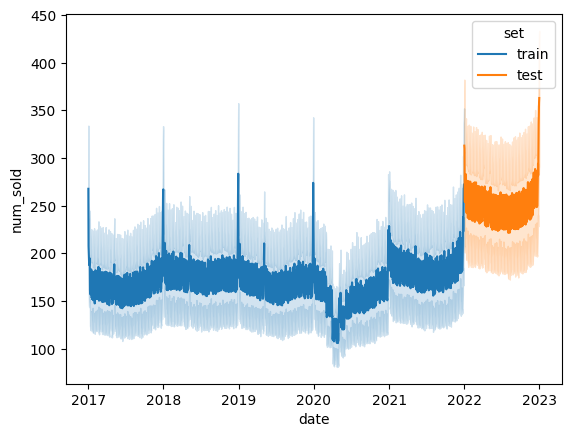

In [30]:
model_rfr = RandomForestRegressor(**{'n_estimators': 551,
 'max_depth': 89,
 'bootstrap': True,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'max_features': 'log2'})
name = "seasonality_holidays_etc_rfr"
model_rfr.fit(X_train, y_train)

df_test['num_sold'] = np.round(model_rfr.predict(X_test)).astype(int)

coef_c = {'Argentina': 4.23, 'Spain': 1.500, 'Japan': 1.14, 'Estonia': 1.62, 'Canada': 0.87}
for c, country in enumerate(df_test['country'].unique()):
    df_test.loc[(df_test['country'] == country), 'num_sold'] *= coef_c[country]

submission_df = df_test[['id', 'num_sold']]
submission_df.to_csv(f'{name}_submission.csv', index=False)
print(f"Submission saved to {name}_submission.csv")
      
# merge df_train with df_test
df_train['set'] = 'train'
df_test['set'] = 'test'
df_temp = pd.concat([df_train, df_test], axis=0, ignore_index=True)
sns.lineplot(x='date', y='num_sold', hue='set', data=df_temp)

In [1]:
! kaggle competitions submit -c playground-series-s3e19 -f seasonality_holidays_etc_rfr_submission.csv -m "seasonality_holidays_etc_rfr_submission"

Successfully submitted to Forecasting Mini-Course Sales



  0%|          | 0.00/495k [00:00<?, ?B/s]
 16%|█▌        | 80.0k/495k [00:00<00:00, 736kB/s]
100%|██████████| 495k/495k [00:01<00:00, 271kB/s] 
